In [32]:
import os, zipfile, shutil, PIL
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

from tensorflow import keras
from google.colab import files
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import RMSprop

In [33]:
!pip install split-folders

import splitfolders
splitfolders.ratio('/content/drive/MyDrive/Colab Notebooks/Dicoding/Rice_Image_Dataset', output="output", seed=1337, ratio=(.8, 0.2)) 


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Copying files: 75000 files [04:17, 291.18 files/s]


In [34]:
BATCH = 64
IMG_WIDTH = 96
IMG_HEIGHT = 96


In [35]:
train_loader = tf.keras.preprocessing.image_dataset_from_directory(
"./output/train",
seed=123,
image_size=(IMG_HEIGHT, IMG_WIDTH),
batch_size=BATCH
)

validation_loader = tf.keras.preprocessing.image_dataset_from_directory(
"./output/val",
seed=123,
image_size=(IMG_HEIGHT, IMG_WIDTH),
batch_size=BATCH
)

Found 60000 files belonging to 5 classes.
Found 15000 files belonging to 5 classes.


In [36]:
class_names = train_loader.class_names
print(class_names)

['Arborio', 'Basmati', 'Ipsala', 'Jasmine', 'Karacadag']


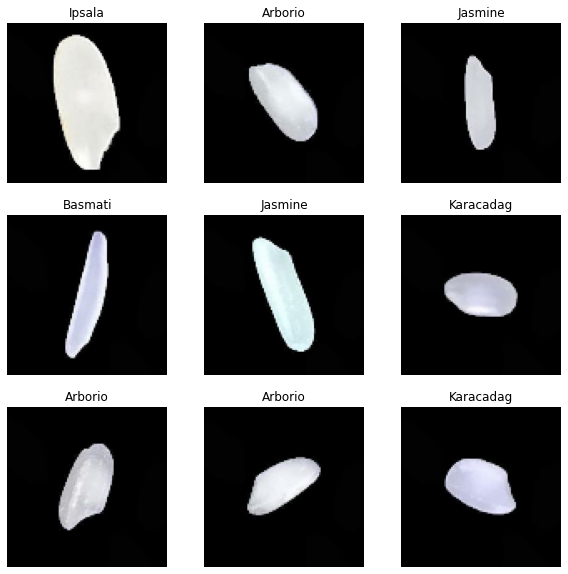

In [37]:
plt.figure(figsize=(10, 10))
for images, labels in train_loader.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [38]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_loader.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
test_dataset = test_loader.cache().prefetch(buffer_size=AUTOTUNE)
val_dataset = validation_loader.cache().prefetch(buffer_size=AUTOTUNE)

In [39]:
data_augmentation = tf.keras.Sequential(
  [
    tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(IMG_HEIGHT, 
                                                              IMG_WIDTH,
                                                              3)),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.1),
    tf.keras.layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

In [40]:
model = tf.keras.models.Sequential([
    data_augmentation,
    tf.keras.layers.experimental.preprocessing.Rescaling(1./255),
    tf.keras.layers.Conv2D(16, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(),
  
    tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    
    tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    
    tf.keras.layers.Conv2D(128, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(len(class_names))
])

In [41]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_2 (Sequential)   (None, 96, 96, 3)         0         
                                                                 
 rescaling_1 (Rescaling)     (None, 96, 96, 3)         0         
                                                                 
 conv2d_4 (Conv2D)           (None, 96, 96, 16)        448       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 48, 48, 16)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 48, 48, 32)        4640      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 24, 24, 32)       0         
 2D)                                                  

In [42]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.999 and logs.get('val_accuracy')>0.999):
      print("\nAkurasi train dan validasi telah mencapai target")
      self.model.stop_training = True
callbacks = myCallback()

In [43]:
epochs = 15
history = model.fit(
  train_dataset,
  validation_data=val_dataset,
  epochs=epochs,
  callbacks = [callbacks]
)

Epoch 1/15
938/938 [==============================] - 92s 31ms/step - loss: 0.2001 - accuracy: 0.9258 - val_loss: 0.0618 - val_accuracy: 0.9799
Epoch 2/15
938/938 [==============================] - 16s 17ms/step - loss: 0.0787 - accuracy: 0.9741 - val_loss: 0.1111 - val_accuracy: 0.9628
Epoch 3/15
938/938 [==============================] - 16s 17ms/step - loss: 0.0396 - accuracy: 0.9877 - val_loss: 0.0593 - val_accuracy: 0.9795
Epoch 4/15
938/938 [==============================] - 16s 17ms/step - loss: 0.0292 - accuracy: 0.9905 - val_loss: 0.0958 - val_accuracy: 0.9694
Epoch 5/15
938/938 [==============================] - 17s 18ms/step - loss: 0.0273 - accuracy: 0.9915 - val_loss: 0.2077 - val_accuracy: 0.9283
Epoch 6/15
938/938 [==============================] - 16s 17ms/step - loss: 0.0233 - accuracy: 0.9930 - val_loss: 0.1312 - val_accuracy: 0.9589
Epoch 7/15
938/938 [==============================] - 15s 16ms/step - loss: 0.0243 - accuracy: 0.9925 - val_loss: 0.0121 - val_accuracy:

In [44]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

Text(0.5, 1.0, 'Training and Validation Accuracy')

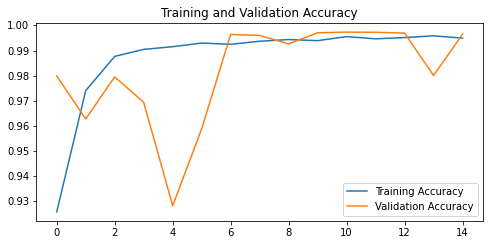

In [45]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

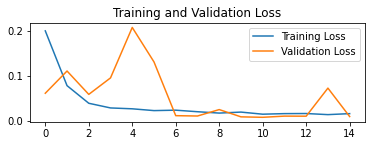

In [46]:
plt.subplot(2, 1, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [47]:

converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

In [48]:
with tf.io.gfile.GFile('model__v1.tflite', 'wb') as f:
  f.write(tflite_model)